In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import numpy as np

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_set = MNIST(root="../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root="../datasets", train=False, download=True, transform=transforms.ToTensor())

In [4]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=True)

In [5]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2, padding=1)
        )

        self.mu = nn.Linear(in_features=32 * 7 * 7, out_features=128)
        self.sigma = nn.Linear(in_features=32 * 7 * 7, out_features=128)

        self.fc_decoder = nn.Linear(in_features=128, out_features=32 * 7 * 7)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16,
                               kernel_size=3, stride=2, padding=1,
                               output_padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1,
                               kernel_size=3, padding=1,
                               output_padding=1, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.reshape(x.shape[0], -1)

        mu = self.mu(encoded)
        sigma = torch.exp(0.5 * self.sigma(encoded))
        eps = torch.randn_like(sigma)
        z_reparametrizes = mu + sigma * eps

        decoded_flat = self.fc_decoder(z_reparametrizes)
        decoded = decoded_flat.view(-1, 32, 7, 7)
        x_reconstructed = self.decoder(decoded)

        return x_reconstructed, mu, sigma, z_reparametrizes

In [6]:
model = VariationalAutoEncoder().to(DEVICE)
# model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=DEVICE))

In [7]:
NUM_EPOCH = 40
LEARNING_RATE = 1e-4

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [8]:
min_loss = float('inf')
train_loss = []

for epoch in range(NUM_EPOCH):

    total_loss = 0
    for img, _ in tqdm(train_loader, desc=f'Epoch: {epoch + 1}'):
        
        img = img.to(DEVICE)
        x_reconstructed, mu, sigma, _ = model(img)

        kl_divergance = - 0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = criterion(x_reconstructed, img) + kl_divergance
        
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_loader)
    train_loss.append(epoch_loss)

    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss:.4f}')

    if epoch_loss < min_loss:
        torch.save(model.state_dict(), "./best_model.pth")
        torch.save(optimizer.state_dict(), "./optimizer_states.pth")
        min_loss = epoch_loss

Epoch: 1: 100%|██████████| 938/938 [00:23<00:00, 40.67it/s]


Epoch: 1 | Loss: 19.7992


Epoch: 2: 100%|██████████| 938/938 [00:24<00:00, 38.68it/s]


Epoch: 2 | Loss: 2.0181


Epoch: 3: 100%|██████████| 938/938 [00:23<00:00, 40.62it/s]


Epoch: 3 | Loss: 0.9547


Epoch: 4: 100%|██████████| 938/938 [00:23<00:00, 40.53it/s]


Epoch: 4 | Loss: 0.6030


Epoch: 5: 100%|██████████| 938/938 [00:24<00:00, 39.07it/s]


Epoch: 5 | Loss: 0.4477


Epoch: 6: 100%|██████████| 938/938 [00:24<00:00, 37.95it/s]


Epoch: 6 | Loss: 0.3691


Epoch: 7: 100%|██████████| 938/938 [00:24<00:00, 38.69it/s]


Epoch: 7 | Loss: 0.3260


Epoch: 8: 100%|██████████| 938/938 [00:22<00:00, 41.58it/s]


Epoch: 8 | Loss: 0.3014


Epoch: 9: 100%|██████████| 938/938 [00:22<00:00, 41.17it/s]


Epoch: 9 | Loss: 0.2868


Epoch: 10: 100%|██████████| 938/938 [00:24<00:00, 38.71it/s]


Epoch: 10 | Loss: 0.2781


Epoch: 11: 100%|██████████| 938/938 [00:22<00:00, 42.15it/s]


Epoch: 11 | Loss: 0.2727


Epoch: 12: 100%|██████████| 938/938 [00:22<00:00, 42.03it/s]


Epoch: 12 | Loss: 0.2694


Epoch: 13: 100%|██████████| 938/938 [00:21<00:00, 43.17it/s]


Epoch: 13 | Loss: 0.2673


Epoch: 14: 100%|██████████| 938/938 [00:21<00:00, 44.60it/s]


Epoch: 14 | Loss: 0.2661


Epoch: 15: 100%|██████████| 938/938 [00:21<00:00, 43.93it/s]


Epoch: 15 | Loss: 0.2653


Epoch: 16: 100%|██████████| 938/938 [00:22<00:00, 42.37it/s]


Epoch: 16 | Loss: 0.2647


Epoch: 17: 100%|██████████| 938/938 [00:22<00:00, 41.75it/s]


Epoch: 17 | Loss: 0.2644


Epoch: 18: 100%|██████████| 938/938 [00:22<00:00, 41.01it/s]


Epoch: 18 | Loss: 0.2641


Epoch: 19: 100%|██████████| 938/938 [00:23<00:00, 40.73it/s]


Epoch: 19 | Loss: 0.2639


Epoch: 20: 100%|██████████| 938/938 [00:21<00:00, 43.94it/s]


Epoch: 20 | Loss: 0.2638


Epoch: 21: 100%|██████████| 938/938 [00:22<00:00, 41.55it/s]


Epoch: 21 | Loss: 0.2637


Epoch: 22: 100%|██████████| 938/938 [00:22<00:00, 42.31it/s]


Epoch: 22 | Loss: 0.2636


Epoch: 23: 100%|██████████| 938/938 [00:22<00:00, 42.61it/s]


Epoch: 23 | Loss: 0.2636


Epoch: 24: 100%|██████████| 938/938 [00:20<00:00, 45.17it/s]


Epoch: 24 | Loss: 0.2635


Epoch: 25: 100%|██████████| 938/938 [00:22<00:00, 41.88it/s]


Epoch: 25 | Loss: 0.2635


Epoch: 26: 100%|██████████| 938/938 [00:21<00:00, 43.72it/s]


Epoch: 26 | Loss: 0.2635


Epoch: 27: 100%|██████████| 938/938 [00:22<00:00, 41.52it/s]


Epoch: 27 | Loss: 0.2634


Epoch: 28: 100%|██████████| 938/938 [00:22<00:00, 42.24it/s]


Epoch: 28 | Loss: 0.2634


Epoch: 29: 100%|██████████| 938/938 [00:21<00:00, 43.03it/s]


Epoch: 29 | Loss: 0.2634


Epoch: 30: 100%|██████████| 938/938 [00:21<00:00, 43.31it/s]


Epoch: 30 | Loss: 0.2634


Epoch: 31: 100%|██████████| 938/938 [00:21<00:00, 43.39it/s]


Epoch: 31 | Loss: 0.2634


Epoch: 32: 100%|██████████| 938/938 [00:21<00:00, 43.08it/s]


Epoch: 32 | Loss: 0.2634


Epoch: 33: 100%|██████████| 938/938 [00:21<00:00, 43.12it/s]


Epoch: 33 | Loss: 0.2638


Epoch: 34: 100%|██████████| 938/938 [00:21<00:00, 42.86it/s]


Epoch: 34 | Loss: 0.2633


Epoch: 35: 100%|██████████| 938/938 [00:23<00:00, 40.69it/s]


Epoch: 35 | Loss: 0.2633


Epoch: 36: 100%|██████████| 938/938 [00:22<00:00, 41.63it/s]


Epoch: 36 | Loss: 0.2633


Epoch: 37: 100%|██████████| 938/938 [00:25<00:00, 36.65it/s]


Epoch: 37 | Loss: 0.2633


Epoch: 38: 100%|██████████| 938/938 [00:21<00:00, 43.46it/s]


Epoch: 38 | Loss: 0.2637


Epoch: 39: 100%|██████████| 938/938 [00:21<00:00, 43.16it/s]


Epoch: 39 | Loss: 0.2633


Epoch: 40: 100%|██████████| 938/938 [00:21<00:00, 43.50it/s]

Epoch: 40 | Loss: 0.2633


## Plotting the train loss curve

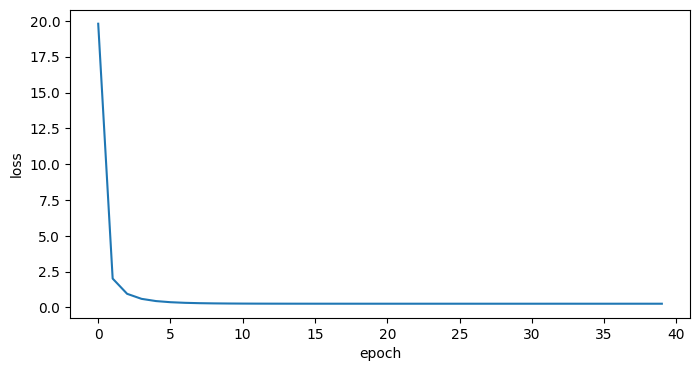

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [10]:
best_model = VariationalAutoEncoder().to(DEVICE)
best_model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

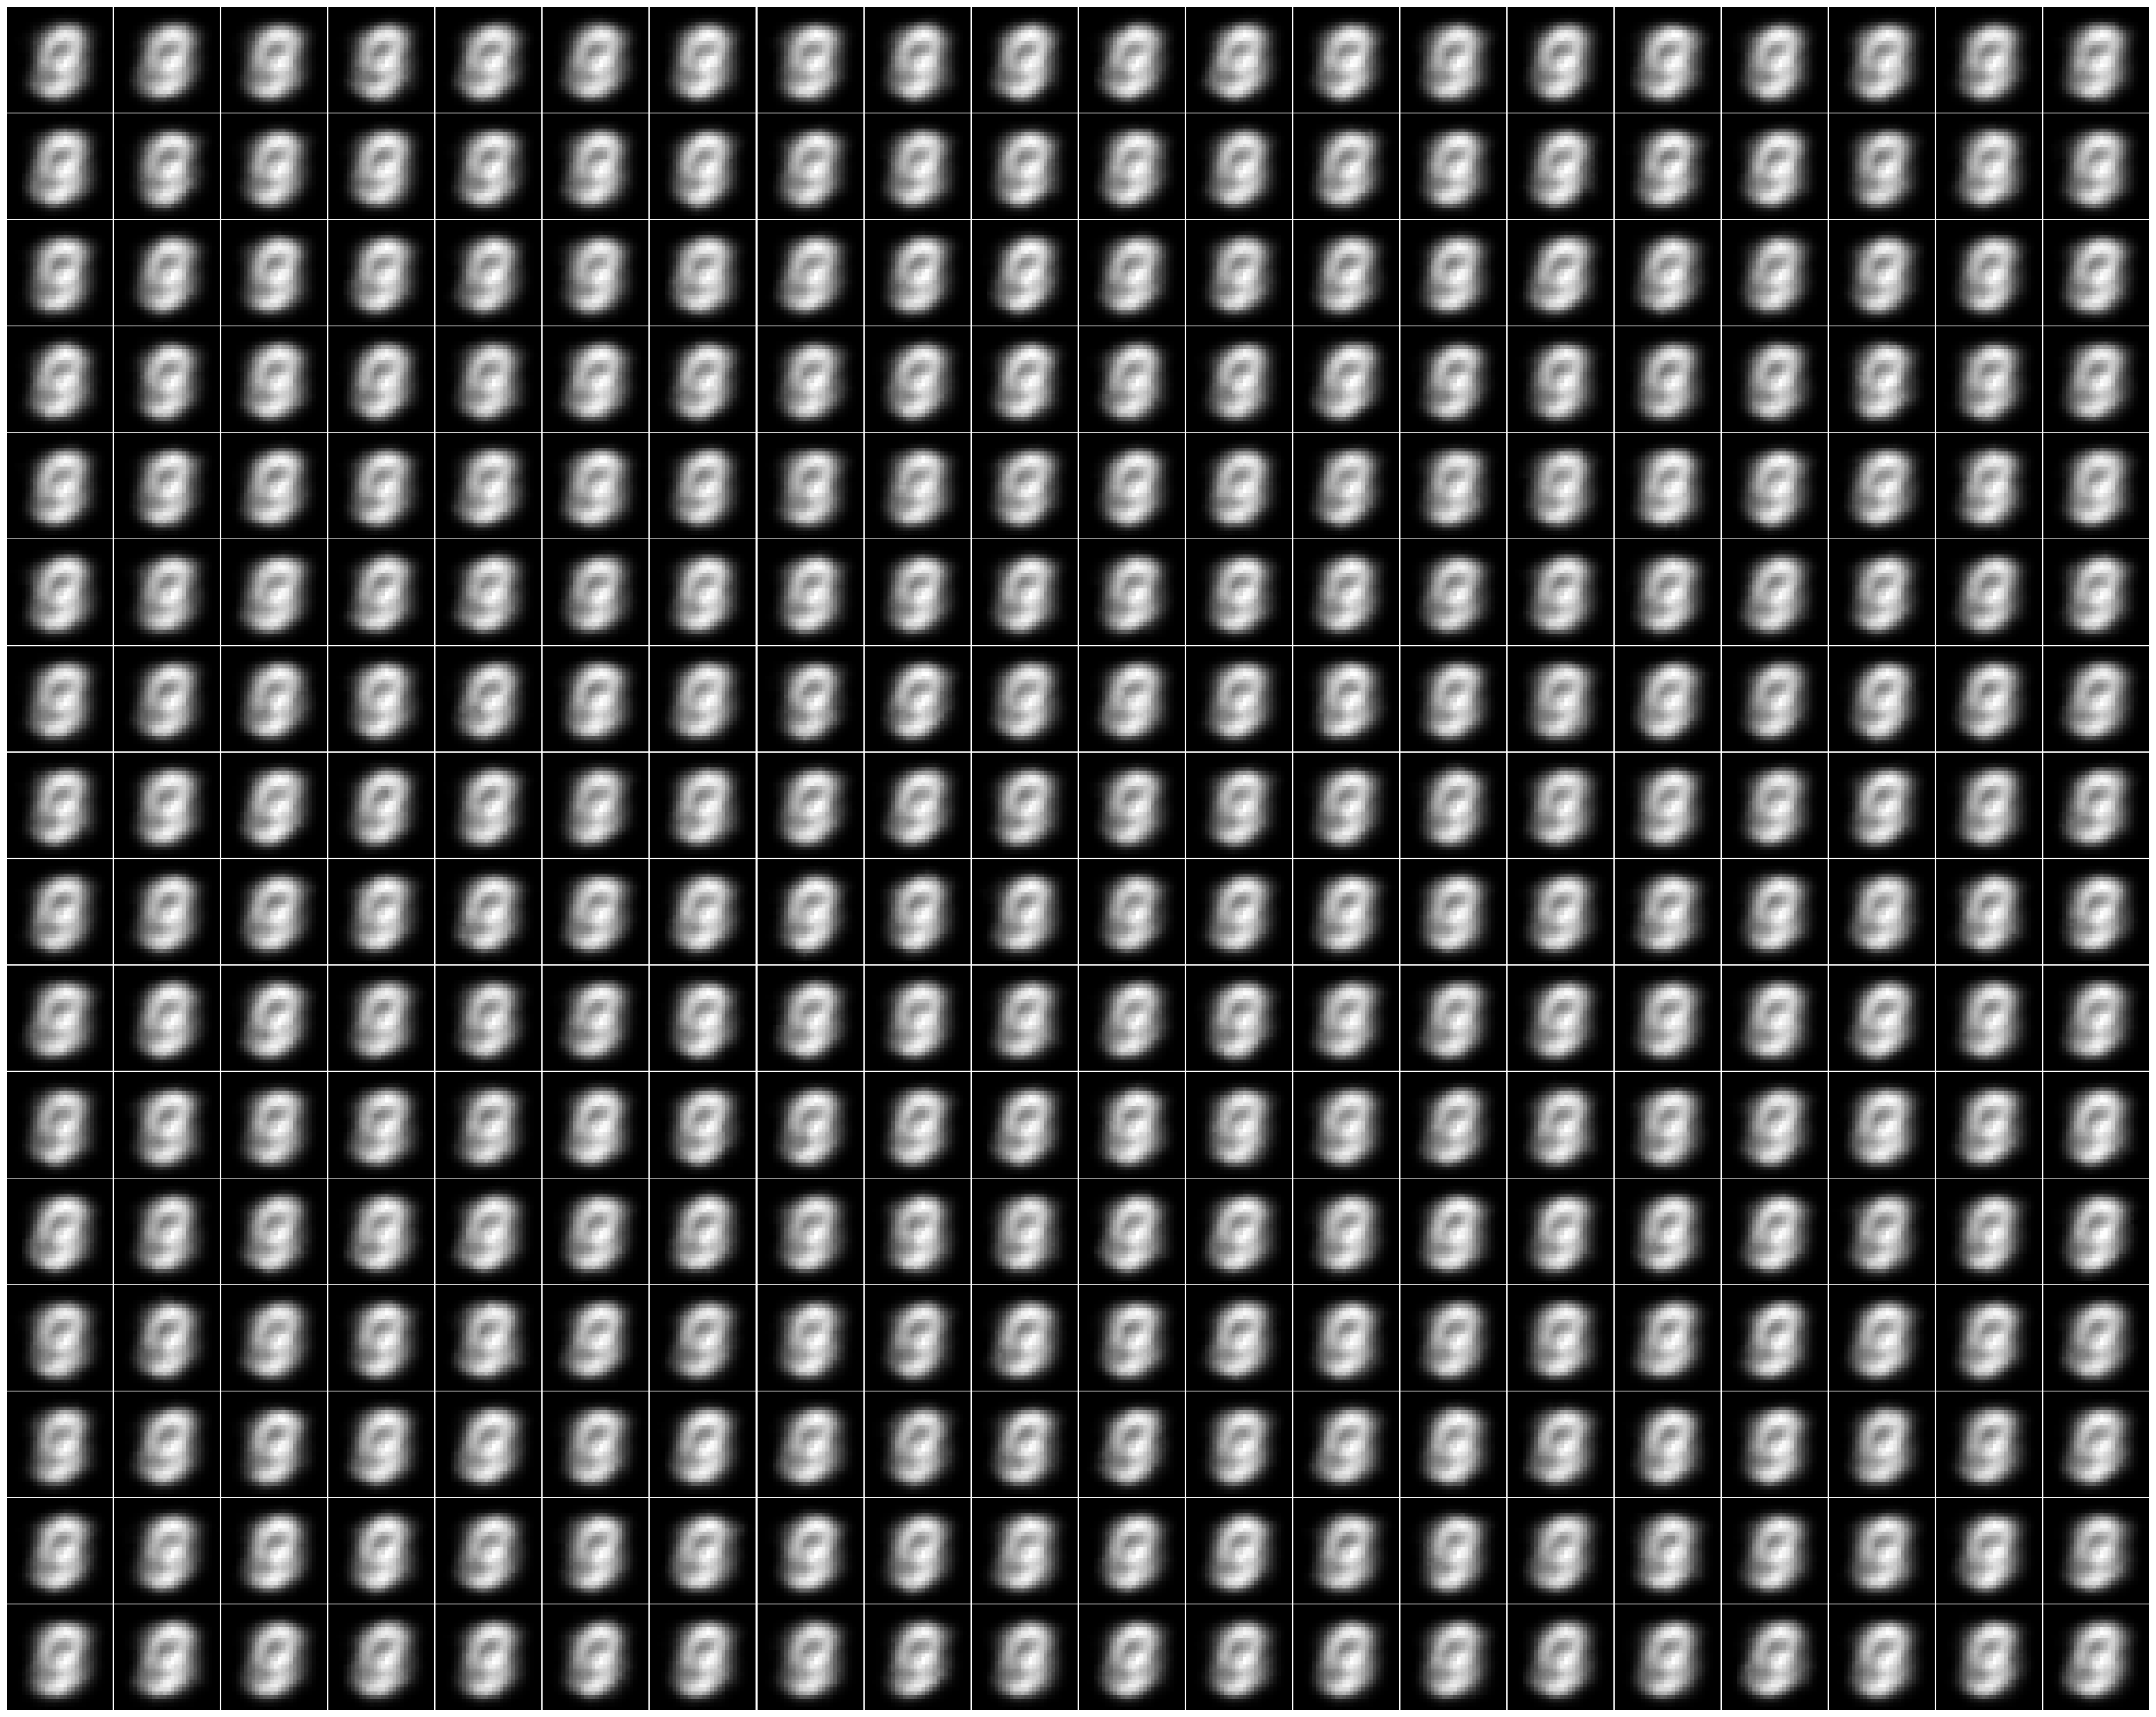

In [11]:
best_model.eval()

nrows, ncols = 16, 20
idx = np.random.choice(len(test_set), nrows * ncols,  replace=False)

with torch.no_grad():
    fig, axes = plt.subplots(nrows, ncols, figsize=(40, 32))
    for i, ax in zip(idx, axes.flatten()):
        img, _ = test_set.__getitem__(i)
        img = img.unsqueeze(0).to(DEVICE)
        out, _, _, _ = best_model(img)
        out = out.squeeze(0).cpu().permute(1, 2, 0)
        ax.imshow(out, cmap="gray")
        ax.axis(False)

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

In [14]:
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.to(DEVICE)
        _, mu, _, _ = best_model(images)
        latent_vectors.extend(mu.cpu())
        labels.extend(targets)

100%|██████████| 200/200 [00:01<00:00, 108.35it/s]


In [15]:
latent_2d = TSNE(n_components=2).fit_transform(np.array(latent_vectors))

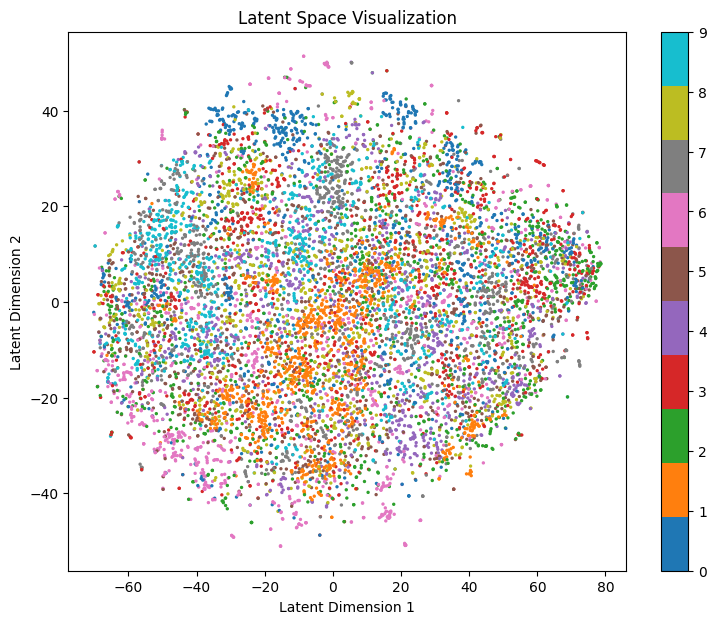

In [16]:
plt.figure(figsize=(9, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()